Frames directory and sequence created 

In [38]:
import os
import cv2
import numpy as np

def extract_frames(video_path, output_dir, video_filename, target_size, frame_sequence_length):
    """
    Extract frames from a video file and save them in a separate directory.

    Args:
        video_path: Path to the video file.
        output_dir: Directory to save the frames.
        video_filename: Name of the video file (without extension) for frame sequence directory name.
        target_size: Tuple (height, width) for resizing frames.
        frame_sequence_length: Number of frames to extract from the video.
    """
    # Create a subdirectory for the frames from the current video
    sequence_dir = os.path.join(output_dir, video_filename)
    os.makedirs(sequence_dir, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate step size to extract frames evenly
    step = max(1, total_frames // frame_sequence_length)

    # Initialize a frame counter
    frame_count = 1

    # Read frames from the video
    for i in range(frame_sequence_length):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        
        if not ret:
            # Break the loop if no frame is read
            break
        
        # Resize the frame and normalize pixel values
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0
        
        # Construct the frame file name and save the frame
        frame_filename = f"frame{frame_count}.jpg"
        frame_path = os.path.join(sequence_dir, frame_filename)
        cv2.imwrite(frame_path, frame * 255)
        
        # Increment the frame counter
        frame_count += 1

    # Release the video capture object
    cap.release()

    # Print the number of frames extracted from the video
    print(f"Extracted {frame_count - 1} frames from video: {video_filename}")

def extract_frames_from_all_classes(dataset_dir, output_dir, target_size=(224, 224), frame_sequence_length=16):
    """
    Extract frames from all videos in each class and save them in separate directories.

    Args:
        dataset_dir: Path to the dataset directory containing class subdirectories.
        output_dir: Output directory to save the extracted frames.
        target_size: Tuple (height, width) for resizing frames.
        frame_sequence_length: Number of frames to extract from each video.
    """
    # Get list of classes in the dataset directory
    classes = sorted([cls for cls in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, cls))])

    # Process each class
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        class_output_dir = os.path.join(output_dir, cls)
        
        # Get list of video files in the current class directory
        video_files = sorted([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        
        # Process each video file in the class
        for video_file in video_files:
            video_path = os.path.join(class_dir, video_file)
            
            # Remove the file extension from the video filename to use as a base for frame sequence directory naming
            video_filename, _ = os.path.splitext(video_file)
            
            print(f"Processing video: {video_file} in class '{cls}'")
            
            # Extract frames from the video and save them in a separate directory for each video
            extract_frames(video_path, class_output_dir, video_filename, target_size, frame_sequence_length)

# Example usage
dataset_dir = 'wlasldaily/'  # Path to the dataset directory containing class subdirectories
output_dir = 'dataset/'  # Path to the output directory to save frame sequences
target_size = (224, 224)  # Resize frames to this size
frame_sequence_length = 16  # Number of frames to extract from each video

# Extract frames from all classes
extract_frames_from_all_classes(dataset_dir, output_dir, target_size, frame_sequence_length)


Processing video: 05728.mp4 in class 'before'
Extracted 16 frames from video: 05728
Processing video: 05729.mp4 in class 'before'
Extracted 16 frames from video: 05729
Processing video: 05730.mp4 in class 'before'
Extracted 16 frames from video: 05730
Processing video: 05731.mp4 in class 'before'
Extracted 16 frames from video: 05731
Processing video: 05732.mp4 in class 'before'
Extracted 16 frames from video: 05732
Processing video: 05733.mp4 in class 'before'
Extracted 16 frames from video: 05733
Processing video: 05734.mp4 in class 'before'
Extracted 16 frames from video: 05734
Processing video: 05739.mp4 in class 'before'
Extracted 16 frames from video: 05739
Processing video: 05740.mp4 in class 'before'
Extracted 16 frames from video: 05740
Processing video: 05741.mp4 in class 'before'
Extracted 16 frames from video: 05741
Processing video: 05742.mp4 in class 'before'
Extracted 16 frames from video: 05742
Processing video: 05743.mp4 in class 'before'
Extracted 16 frames from video

Checking the no of classes 

In [39]:
import os

def count_classes(data_dir):
    """
    Count the number of classes in the dataset.

    Args:
        data_dir: Path to the data directory where classes are organized in subdirectories.

    Returns:
        The number of classes (subdirectories) in the data directory.
    """
    # Get a list of all items in the data directory
    items = os.listdir(data_dir)
    
    # Filter the items to include only directories (i.e., classes)
    classes = [item for item in items if os.path.isdir(os.path.join(data_dir, item))]
    
    # Count the number of classes
    num_classes = len(classes)
    
    return num_classes

# Example usage
data_dir = 'dataset/'  # Specify the path to your data directory
num_classes = count_classes(data_dir)
print(f"The dataset contains {num_classes} classes.")

class FrameDataGenerator:
    def __init__(self, data_dir, target_size, batch_size=32, desired_classes=None):
        """
        Initialize the FrameDataGenerator.

        Args:
            data_dir: Path to the directory containing the data.
            target_size: Tuple (height, width) for resizing frames.
            batch_size: Number of samples per batch.
            desired_classes: List of class names to include (default is None, which includes all classes).
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.batch_size = batch_size

        # Filter and sort the classes as per the desired_classes
        if desired_classes:
            self.classes = sorted([cls for cls in desired_classes if cls in os.listdir(data_dir)])
        else:
            self.classes = sorted(os.listdir(data_dir))

        # Create a dictionary mapping class names to indices
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load frame sequences and labels
        self.frame_sequences, self.labels = self._load_frame_sequences_and_labels()

    def _load_frame_sequences_and_labels(self):
        """
        Load frame sequence directories and corresponding labels from the data directory.

        Returns:
            frame_sequences: List of frame sequence directories.
            labels: List of labels corresponding to the frame sequences.
        """
        frame_sequences = []
        labels = []

        # Iterate through each class directory
        for cls in self.classes:
            class_dir = os.path.join(self.data_dir, cls)
            print(f"Processing class directory: {class_dir}")  # Debug print
            
            # List all frame sequence directories within the class directory
            sequence_dirs = sorted([seq for seq in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, seq))])
            print(f"Found frame sequence directories in '{cls}': {sequence_dirs}")  # Debug print

            # For each frame sequence directory, add the sequence and its corresponding label
            for seq in sequence_dirs:
                sequence_path = os.path.join(class_dir, seq)
                frame_sequences.append(sequence_path)
                labels.append(self.class_indices[cls])

        print(f"Loaded {len(frame_sequences)} frame sequences with labels.")
        return frame_sequences, labels


The dataset contains 19 classes.


Data Generators 

In [29]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class FrameDataGenerator(Sequence):
    def __init__(self, data_dir, target_size, batch_size=32, desired_classes=None):
        """
        Initialize the FrameDataGenerator.

        Args:
            data_dir: Path to the directory containing the data.
            target_size: Tuple (height, width) for resizing frames.
            batch_size: Number of samples per batch.
            desired_classes: List of class names to include (default is None, which includes all classes).
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.batch_size = batch_size

        # Filter and sort the classes as per the desired_classes
        if desired_classes:
            self.classes = sorted([cls for cls in desired_classes if cls in os.listdir(data_dir)])
        else:
            self.classes = sorted(os.listdir(data_dir))

        # Create a dictionary mapping class names to indices
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load frames and labels
        self.frame_files, self.labels, self.video_frame_counts = self._load_frames_and_labels()

    def _load_frames_and_labels(self):
        """
        Load frame file paths and corresponding labels from the data directory.

        Returns:
            frame_files: List of frame file paths.
            labels: List of labels corresponding to the frames.
            video_frame_counts: Dictionary mapping video directory paths to their frame counts.
        """
        frame_files = []
        labels = []
        video_frame_counts = {}

        # Iterate through each class
        for cls in self.classes:
            class_dir = os.path.join(self.data_dir, cls)
            
            # Check if the directory exists
            if not os.path.exists(class_dir):
                print(f"Class directory '{class_dir}' does not exist.")
                continue
            
            # Iterate through each video directory within the class directory
            video_dirs = [os.path.join(class_dir, vid) for vid in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, vid))]

            print(f"Processing class '{cls}' with {len(video_dirs)} video directories.")

            # Process each video directory
            for vid_dir in video_dirs:
                # List frames in the video directory
                frames = sorted(os.listdir(vid_dir))

                # Keep track of the frame count in this video directory
                video_frame_counts[vid_dir] = len(frames)

                print(f"Video directory '{vid_dir}' contains {len(frames)} frames.")

                # Iterate through each frame in the video directory
                for frame in frames:
                    frame_path = os.path.join(vid_dir, frame)
                    frame_files.append(frame_path)
                    labels.append(self.class_indices[cls])

        print(f"Loaded {len(frame_files)} frames with labels.")
        return frame_files, labels, video_frame_counts

    def __len__(self):
        """
        Returns the number of batches in the dataset.
        """
        return len(self.frame_files) // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Args:
            index: Batch index.

        Returns:
            batch_frames: Batch of frames as a numpy array.
            batch_labels: One-hot encoded labels as a numpy array.
        """
        start_index = index * self.batch_size
        end_index = start_index + self.batch_size

        # Get the frame files and labels for the current batch
        batch_files = self.frame_files[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]

        # Load frames and process them
        batch_frames = []
        for frame_file in batch_files:
            frame = self.load_frame(frame_file)
            batch_frames.append(frame)

        # Convert lists to numpy arrays
        batch_frames = np.array(batch_frames)
        # Convert labels to one-hot encoded form
        batch_labels = to_categorical(batch_labels, num_classes=len(self.classes))

        return batch_frames, batch_labels

    def load_frame(self, frame_path):
        """
        Load a frame from a given path.

        Args:
            frame_path: Path to the frame.

        Returns:
            frame: Numpy array of the frame.
        """
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, self.target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        return frame

# Define the parameters
target_size = (224, 224)  # Resize frames to this size
batch_size = 32

# Create the data generators for train and validation sets
train_generator = FrameDataGenerator('dataset/', target_size, batch_size)
val_generator = FrameDataGenerator('validation/', target_size, batch_size)

# You can now use these data generators for training a model.


Processing class 'before' with 15 video directories.
Video directory 'dataset/before\05728' contains 16 frames.
Video directory 'dataset/before\05729' contains 16 frames.
Video directory 'dataset/before\05730' contains 16 frames.
Video directory 'dataset/before\05731' contains 16 frames.
Video directory 'dataset/before\05732' contains 16 frames.
Video directory 'dataset/before\05733' contains 16 frames.
Video directory 'dataset/before\05734' contains 16 frames.
Video directory 'dataset/before\05739' contains 16 frames.
Video directory 'dataset/before\05740' contains 16 frames.
Video directory 'dataset/before\05741' contains 16 frames.
Video directory 'dataset/before\05742' contains 16 frames.
Video directory 'dataset/before\05743' contains 16 frames.
Video directory 'dataset/before\05749' contains 16 frames.
Video directory 'dataset/before\05750' contains 16 frames.
Video directory 'dataset/before\65167' contains 16 frames.
Processing class 'book' with 5 video directories.
Video direct

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_2d_cnn_model(input_shape, num_classes):
    """Create a 2D CNN model for frame classification with the specified number of classes."""
    model = Sequential([
        # First 2D convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        
        # Second 2D convolutional layer
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Third 2D convolutional layer
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Flatten the 2D data to 1D
        Flatten(),
        
        # Fully connected dense layer
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        # Output layer with softmax activation for the given number of classes
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Define the input shape and number of classes
input_shape = (224, 224, 3)  # Height, width, channels (RGB)
num_classes = 19  # Number of classes in the dataset

# Create the model
model = create_2d_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 128)     

Epoch 1/5
83/83 [==============================] - 227s 3s/step - loss: 2.9417 - accuracy: 0.0828 - val_loss: 2.9346 - val_accuracy: 0.1321
Epoch 2/5
83/83 [==============================] - 206s 2s/step - loss: 2.7975 - accuracy: 0.1514 - val_loss: 2.6455 - val_accuracy: 0.1648
Epoch 3/5
83/83 [==============================] - 205s 2s/step - loss: 2.6813 - accuracy: 0.2048 - val_loss: 2.3287 - val_accuracy: 0.3295
Epoch 4/5
83/83 [==============================] - 205s 2s/step - loss: 2.3167 - accuracy: 0.2959 - val_loss: 1.9490 - val_accuracy: 0.5511
Epoch 5/5
22/22 [==============================] - 16s 725ms/step - loss: 1.3336 - accuracy: 0.6207
Model evaluation on validation data: Loss = 1.3336386680603027, Accuracy = 0.6207386255264282


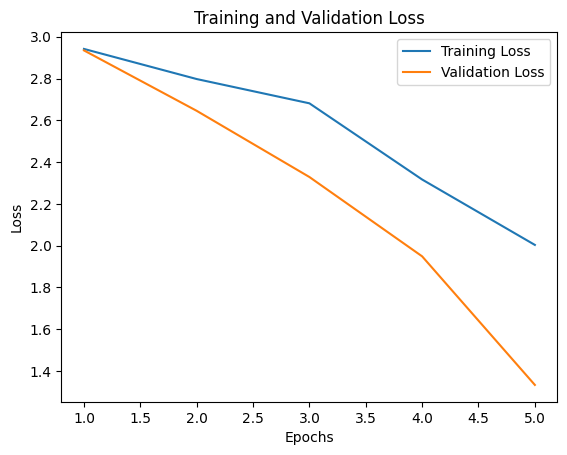

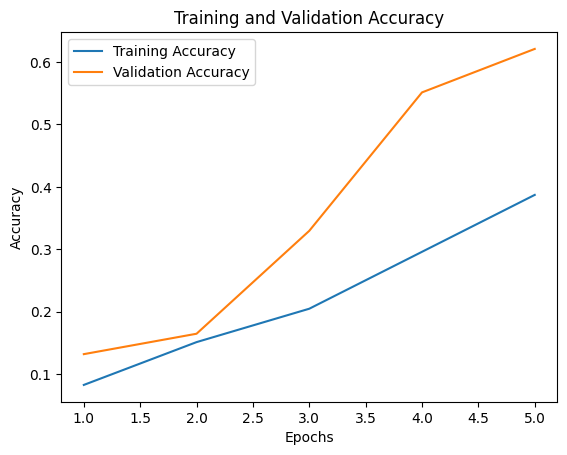

Model saved to try2cnnmodel.h5


In [32]:
import matplotlib.pyplot as plt

# Train the model using the train generator and validate using the validation generator
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Adjust the number of epochs as needed
    verbose=1
)

# Evaluate the model
try:
    # Set steps explicitly if necessary
    steps = len(val_generator) if len(val_generator) > 0 else None
    evaluation = model.evaluate(val_generator, steps=steps)
    print(f"Model evaluation on validation data: Loss = {evaluation[0]}, Accuracy = {evaluation[1]}")
except Exception as e:
    print(f"An error occurred during model evaluation: {e}")

# Plot training and validation loss and accuracy
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy from the history object.
    
    Args:
        history: Keras history object returned by model.fit().
    """
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot loss
    plt.figure()
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the plotting function to visualize training and validation curves
plot_training_history(history)

# Save the trained model
model_path = 'try2cnnmodel.h5'  # Specify the path to save the model
model.save(model_path)
print(f"Model saved to {model_path}")


Epoch 1/10
83/83 [==============================] - 213s 3s/step - loss: 1.5672 - accuracy: 0.5124 - val_loss: 0.9312 - val_accuracy: 0.7074
Epoch 2/10
83/83 [==============================] - 250s 3s/step - loss: 1.1705 - accuracy: 0.6570 - val_loss: 0.8161 - val_accuracy: 0.8040
Epoch 3/10
83/83 [==============================] - 231s 3s/step - loss: 0.8470 - accuracy: 0.7323 - val_loss: 0.6644 - val_accuracy: 0.8054
Epoch 4/10
83/83 [==============================] - 210s 3s/step - loss: 0.6951 - accuracy: 0.7899 - val_loss: 0.5173 - val_accuracy: 0.8253
Epoch 5/10
83/83 [==============================] - 211s 3s/step - loss: 0.5565 - accuracy: 0.8253 - val_loss: 0.5818 - val_accuracy: 0.8310
Epoch 6/10
83/83 [==============================] - 209s 3s/step - loss: 0.4376 - accuracy: 0.8645 - val_loss: 0.4700 - val_accuracy: 0.8551
Epoch 7/10
83/83 [==============================] - 203s 2s/step - loss: 0.3223 - accuracy: 0.8961 - val_loss: 0.3345 - val_accuracy: 0.8991
Epoch 8/10
83

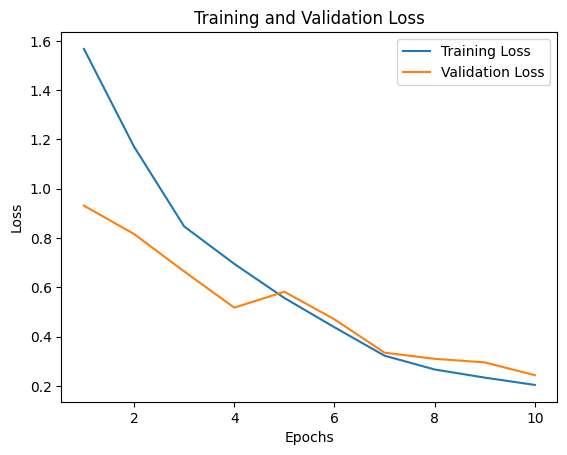

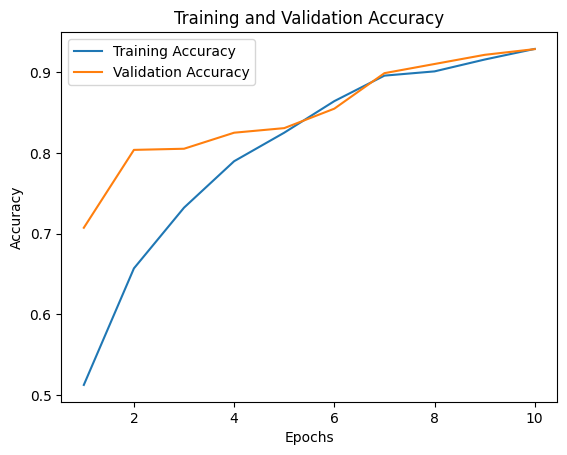

Model saved to 10epoccnnmodel.h5


In [33]:
import matplotlib.pyplot as plt

# Train the model using the train generator and validate using the validation generator
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust the number of epochs as needed
    verbose=1
)

# Evaluate the model
try:
    # Set steps explicitly if necessary
    steps = len(val_generator) if len(val_generator) > 0 else None
    evaluation = model.evaluate(val_generator, steps=steps)
    print(f"Model evaluation on validation data: Loss = {evaluation[0]}, Accuracy = {evaluation[1]}")
except Exception as e:
    print(f"An error occurred during model evaluation: {e}")

# Plot training and validation loss and accuracy
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy from the history object.
    
    Args:
        history: Keras history object returned by model.fit().
    """
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot loss
    plt.figure()
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the plotting function to visualize training and validation curves
plot_training_history(history)

# Save the trained model
model_path = '10epoccnnmodel.h5'  # Specify the path to save the model
model.save(model_path)
print(f"Model saved to {model_path}")


In [37]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load the saved model
model_path = '10epoccnnmodel.h5'  # Specify the path to the saved model file
try:
    loaded_model = load_model(model_path)
    print(f"Model loaded from {model_path}")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

def extract_frames_from_video(video_path, target_size, n_frames):
    """
    Extract frames from a video.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) to resize frames.
        n_frames: Number of frames to extract.

    Returns:
        frames: A numpy array of extracted and preprocessed frames.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return None
    
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    
    # Calculate step size to extract frames evenly
    step = max(1, total_frames // n_frames)
    print(f"Step size for frame extraction: {step}")

    for i in range(n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if ret:
            # Resize the frame and normalize pixel values
            frame = cv2.resize(frame, target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame / 255.0
            frames.append(frame)
        else:
            print(f"Failed to read frame at step {i} from the video.")
    
    cap.release()
    
    if len(frames) == 0:
        print("No frames extracted from the video.")
        return None

    # Convert the list of frames to a numpy array
    frames = np.array(frames)
    print(f"Extracted frames shape: {frames.shape}")
    
    return frames

def test_video(model, video_path, target_size, n_frames):
    """
    Test the trained model on a video and classify it.
    """
    try:
        # Extract frames from the video
        frames = extract_frames_from_video(video_path, target_size, n_frames)
        if frames is None:
            print("No frames available for testing.")
            return None
        
        # Initialize a list to store predictions for each frame
        frame_predictions = []
        
        # Iterate over each frame and make predictions
        for frame in frames:
            # Add batch dimension to the frame
            frame = np.expand_dims(frame, axis=0)
            
            # Make prediction for the current frame
            prediction = model.predict(frame)
            
            # Append the prediction to the list
            frame_predictions.append(prediction)
            print(f"Prediction for the frame: {prediction}")

        # Convert the list of predictions to a numpy array
        frame_predictions = np.array(frame_predictions)
        
        # Calculate the mean prediction across frames
        mean_prediction = np.mean(frame_predictions, axis=0)
        print(f"Mean prediction across frames: {mean_prediction}")
        
        # Determine the class with the highest probability
        predicted_class = np.argmax(mean_prediction)
        print(f"The predicted class for the video is: {predicted_class}")
        
        return predicted_class
    except Exception as e:
        print(f"An error occurred during video testing: {e}")
        return None

# Define video path for testing
video_path = 'test/write/64056.mp4'

# Define target size and number of frames per video
target_size = (224, 224)
n_frames = 16

# Test the video
predicted_class = test_video(loaded_model, video_path, target_size, n_frames)
if predicted_class is not None:
    print(f"The predicted class for the video is: {predicted_class}")


Model loaded from 10epoccnnmodel.h5
Total frames in video: 85
Step size for frame extraction: 5
Extracted frames shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 459ms/step
Prediction for the frame: [[4.0350380e-05 1.6873343e-04 1.8805272e-03 1.1563306e-03 7.0554889e-03
  2.4841302e-03 2.3609186e-03 1.0741205e-03 3.9031354e-03 1.6515508e-03
  1.1024586e-03 1.8495900e-03 6.9966246e-03 9.5045084e-01 2.8420988e-04
  2.6358755e-05 2.2664059e-05 1.6176952e-02 1.3150556e-03]]
1/1 [==============================] - 0s 155ms/step
Prediction for the frame: [[4.3114760e-05 2.0262509e-04 1.9886664e-03 1.2979122e-03 7.1698339e-03
  2.5884761e-03 2.6847625e-03 1.3046346e-03 4.0948004e-03 1.9503676e-03
  1.1980841e-03 1.8402124e-03 7.3164776e-03 9.4722271e-01 3.1083953e-04
  3.1258169e-05 2.4859253e-05 1.7266922e-02 1.4635522e-03]]
1/1 [==============================] - 0s 214ms/step
Prediction for the frame: [[4.4878361e-05 1.9876051e-04 1.9435566e-03 1.2975197e-03 6.8439171e-03
 